# HLCA Model Criticism

In [1]:
from scvi_criticism import run_ppc, PPC, PPCPlot
import scvi
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import torch
import gc
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import mplscience
import seaborn as sns
import scipy
from pathlib import Path
import math
from scvi.data._download import _download
from scvi.data import cellxgene
import os
from scvi.model.base import ArchesMixin

scvi.settings.seed = 1

# plotting commands for the styling
# sns.reset_orig()
mplscience.set_style(reset_current=True, name="default")

%load_ext autoreload
%autoreload 2

Global seed set to 0
Global seed set to 1


## 1️⃣ Get the data and train models

Following [this](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/api_overview.html) tutorial, we will use the HCA dataset.

The dataset used is a subset of the heart cell atlas dataset:
Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., … & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.

Let's train the model as usual. Also save the model and data on disk as we'll need them later.

In [7]:
local_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HCA"

In [37]:
adata = scvi.data.heart_cell_atlas_subsampled(save_path=local_dir)
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HCA/hca_subsampled_20k.h5ad already 
         downloaded                                                                                                


Train the model.

In [46]:
good_model_path = f"{local_dir}/good_model"

In [10]:
adata2 = adata.copy()

In [6]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)
model = scvi.model.SCVI(adata)
model.train()

model.save(good_model_path, save_anndata=True)

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/model.pt already downloaded    


/Users/valehvpa/GitRepos/scvi-tools/scvi/data/_utils.py:175: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/Users/valehvpa/GitRepos/scvi-tools/scvi/data/_utils.py:175: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Train a bad model -- not enough epochs.

In [38]:
bad_model_1_path = f"{local_dir}/bad_model_1"

In [39]:
adata = adata2.copy()

In [40]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)
model_bad_1 = scvi.model.SCVI(adata)
model_bad_1.train(max_epochs=5)

model_bad_1.save(bad_model_1_path, save_anndata=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 5/5: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it, loss=292, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it, loss=292, v_num=1]


Train a bad model -- too small of a latent space.

In [25]:
bad_model_2_path = f"{local_dir}/bad_model_2"

In [26]:
adata = adata2.copy()

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)
model_bad_2 = scvi.model.SCVI(adata, n_latent=2)
model_bad_2.train()

model_bad_2.save(bad_model_2_path, save_anndata=True)

## 2️⃣ Evaluate

In [36]:
temp_fig_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs"

Evaluate the good model

In [47]:
model = scvi.model.SCVI.load(good_model_path)

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HCA/good_model/model.pt already     
         downloaded                                                                                                


In [48]:
# run ppc+cv
n_samples = 5
ppc = run_ppc(adata, model, "cv_cell", n_samples = n_samples, layer="counts")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=True, plt_type="hist2d")

fig_path = f'{temp_fig_dir}/hca_good_model_ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

KeyboardInterrupt: 

In [49]:
# run ppc+DE
ppc = run_ppc(adata, model, "diff_exp", n_samples = 1, de_groupby="cell_type")

ppc_plt.plot_diff_exp(
    "SCVI",
    plot_kind="summary_box",
)
fig_path = f'{temp_fig_dir}/good_model_de_summary_barplot.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

KeyError: 'diff_exp'

Evaluate the bad model 1

In [ ]:
model = scvi.model.SCVI.load(bad_model_1_path)

INFO     model=SCVI | metric=cv_cell | n_cells=18641:                                                              
         Mean Absolute Error=1.13,                                                                                 
         Mean Squared Error=2.66                                                                                   
         Pearson correlation=0.63                                                                                  
         Spearman correlation=0.70                                                                                 
         r^2=0.37                                                                                                  
                                                                                                                   


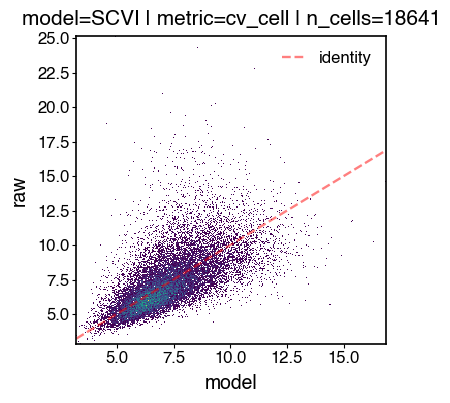

In [24]:
# run ppc+cv for bad model 1
n_samples = 5
ppc = run_ppc(adata, model_bad_1, "cv_cell", n_samples = n_samples, layer="counts")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=True, plt_type="hist2d")

fig_path = f'{temp_fig_dir}/hca_bad_model_1_ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

In [32]:
# run ppc+DE
ppc = run_ppc(adata, model, "diff_exp", n_samples = 1, de_groupby="cell_type")

ppc_plt.plot_diff_exp(
    "SCVI",
    plot_kind="summary_box",
)
fig_path = f'{temp_fig_dir}/de_summary_barplot.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

Evaluate the bad model 2

In [41]:
model = scvi.model.SCVI.load(bad_model_2_path)

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HCA/bad_model_2/model.pt already    
         downloaded                                                                                                


INFO     model=SCVI | metric=cv_cell | n_cells=18641:                                                              
         Mean Absolute Error=0.94,                                                                                 
         Mean Squared Error=1.96                                                                                   
         Pearson correlation=0.74                                                                                  
         Spearman correlation=0.79                                                                                 
         r^2=0.53                                                                                                  
                                                                                                                   


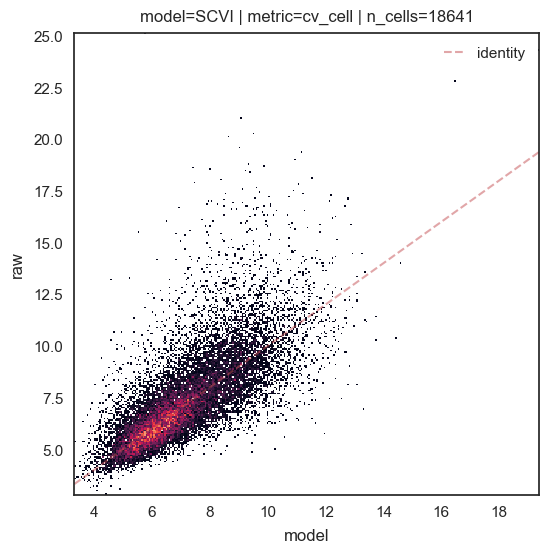

In [42]:
# run ppc+cv
n_samples = 5
ppc = run_ppc(adata, model, "cv_cell", n_samples = n_samples, layer="counts")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=True, plt_type="hist2d")

fig_path = f'{temp_fig_dir}/hca_bad_model_2_ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

In [44]:
# run ppc+DE
ppc = run_ppc(adata, model, "diff_exp", n_samples = 1, de_groupby="cell_type")

ppc_plt.plot_diff_exp(
    "SCVI",
    plot_kind="summary_box",
)
fig_path = f'{temp_fig_dir}/bad_model_2_de_summary_barplot.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

KeyError: 'diff_exp'